In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage
from skimage.measure import label, find_contours
from skimage.morphology import binary_dilation, disk
from skimage.draw import ellipse
from skimage.io import imread

%matplotlib inline

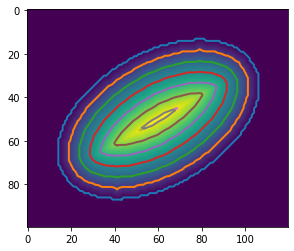

In [3]:
img = np.zeros((100, 120), dtype=np.uint8)
rr, cc = ellipse(50, 60, 30, 50, rotation=np.deg2rad(30))
img[rr, cc] = 1

distance = ndimage.distance_transform_edt(img)
max_val = np.max(distance)

levels = np.linspace(0, max_val-1, 7)
contours = [find_contours(distance, level) for level in levels]

plt.imshow(distance)
for contour in contours:
    for c in contour:
        plt.plot(c[:,1], c[:,0], linewidth=2)

Now, measure the sum of pixel intensities between rings.

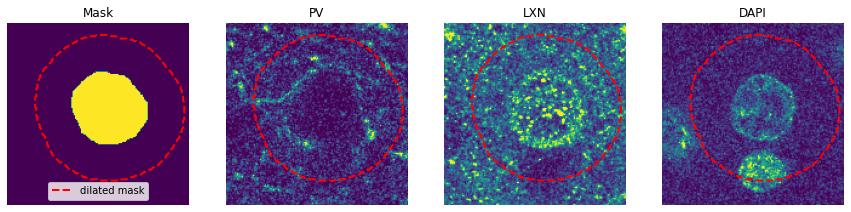

In [4]:
cell_red = imread('data/surround_cell_RhRX.tif')
cell_green = imread('data/surround_cell_AF488.tif')
cell_blue = imread('data/surround_cell_DAPI.tif')
cell_mask = imread('data/surround_cell_mask.tif')

images = [cell_mask, cell_red, cell_green, cell_blue]
titles = ['Mask', 'PV', 'LXN', 'DAPI']
colors = ['', 'red', 'green', 'blue']

# Dilate mask
selem = disk(30)
dil_mask = binary_dilation(cell_mask, selem)
dil_mask_cont = find_contours(dil_mask)[0]

# Plot
fig, axs = plt.subplots(1, len(images), figsize=(15,5))
axs = axs.ravel()

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    line = ax.plot(dil_mask_cont[:,1], dil_mask_cont[:,0], linewidth=2, linestyle='--', c='red', label='dilated mask')
    ax.set_title(title)

for ax in axs:
    ax.axis('off')

axs[0].legend(loc='lower center')

plt.show()

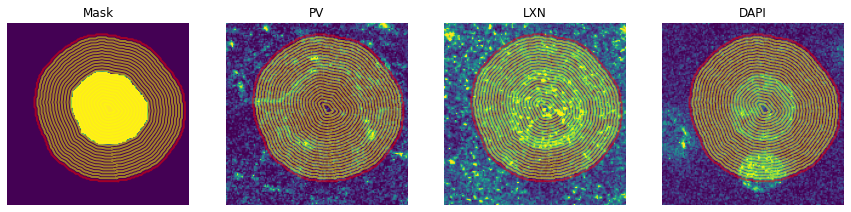

In [10]:
distance = ndimage.distance_transform_edt(dil_mask)
dist_max = np.max(distance)

levels = np.linspace(0, dist_max, 25)
contours = [find_contours(distance, level) for level in levels]

# Plot
fig, axs = plt.subplots(1, len(images), figsize=(15,5))
axs = axs.ravel()

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    for j, contour in enumerate(contours[0:-1]): # ignore the last contour, it is usually too small
        c = contour[0]
        color = 'red' if (j == 0) else 'yellow' # change color for outer most line
        ax.plot(c[:,1], c[:,0], linewidth=2, c=color, linestyle='-', alpha=0.5)
    ax.set_title(title)

for ax in axs:
    ax.axis('off')

plt.show()

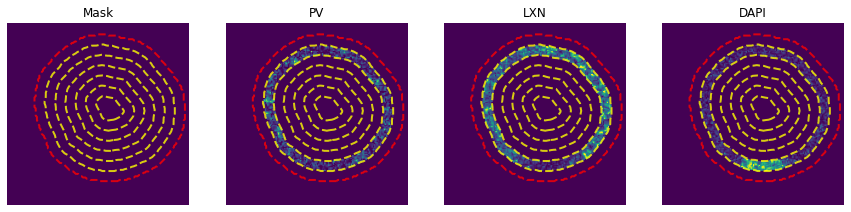

In [6]:
# create a mask for the zone between contours
def mask_between_contours(distance_map, outer_level, inner_level):
    # Only keep area where outer is True and inner is False
    return (distance_map > outer_level) == (distance_map > inner_level)

levels = np.linspace(0, dist_max, 8)
contours = [find_contours(distance, level) for level in levels]

# Plot
fig, axs = plt.subplots(1, len(images), figsize=(15,5))
axs = axs.ravel()

for ax, img, title in zip(axs, images, titles):
    for j, contour in enumerate(contours[0:-1]): # ignore the last contour, it is usually too small
        c = contour[0]
        color = 'red' if (j == 0) else 'yellow' # change color for outer most line
        ax.plot(c[:,1], c[:,0], linewidth=2, c=color, linestyle='--', alpha=0.8)
    mask = mask_between_contours(distance, levels[1], levels[2])
    masked_img = np.ma.masked_array(img, mask, fill_value=0)
    ax.imshow(masked_img.filled())
    ax.set_title(title)

for ax in axs:
    ax.axis('off')

plt.show()


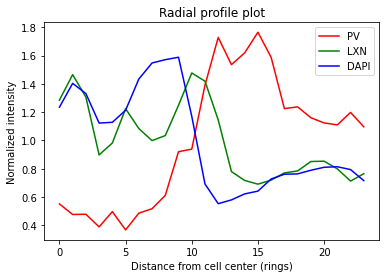

In [9]:
def get_radial_profile(img, dist_map, n_levels):
    dist_max = np.max(distance)
    levels = np.linspace(0, dist_max, n_levels)
    values = np.empty(n_levels - 1)
    areas = np.empty(n_levels - 1)

    for i in range(len(levels) - 1):
        mask = mask_between_contours(distance, levels[i], levels[i + 1])
        area = (mask == False).sum()
        img_masked = np.ma.masked_array(img, mask, fill_value=0)
        
        values[i] = img_masked.sum()
        areas[i] = area

    return values, areas

def normalize(values, areas):
    return (values / areas) / (values / areas).mean()

fig, ax = plt.subplots(1, 1)
for img, title, color in zip(images[1:], titles[1:], colors[1:]):
    values, areas = get_radial_profile(img, distance, 25)
    normalized = normalize(values, areas)
    ax.plot(np.flip(normalized), c=color, label=title)

ax.set_title('Radial profile plot')
ax.set_xlabel('Distance from cell center (rings)')
ax.set_ylabel('Normalized intensity')
ax.legend()

plt.show()